This notebook evaluates performance gains of `CudaCosineGreedy` against `matchms`.

Performance depends heavily on used hardware, as well as how correlated the spectra are with each other, (i.e. on average, how many common pairs of peaks do spectra have). 

This specific notebook evaluates the performance given the following below arguments (feel free to change these):

In [1]:
# We compare pairwise similarity performance on `spectra_file`
# We can use pickled version for much faster loading times
spectra_file = 'ALL_GNPS.pickle'

# We take a random sample of spectra from said file

# Minimum size:
chunk_sizes_min = 32

# Maximum size
chunk_sizes_max = 5_000

# Minimum size
chunk_sizes_min_cu = 32

# Maximum size
chunk_sizes_max_cu = 5_000

# how many points to evaluate (in logspace) between min and max
num_evals = 15

# max number of peaks to retain in any spectra - larger numbers are marginally more accurate, but much slower
max_peaks = 1024

# optimal batch size is hardware-dependent, but usually the best number is the largest the hardware can handle (without an OOM error)
batch_size = 2048

# Hardware matters! These results are only repeatable using this GPU (shown as an output)
! nvidia-smi -L
! echo Number of CPU cores $(nproc)

GPU 0: NVIDIA GeForce RTX 4090 (UUID: GPU-89eb76f5-a36a-4464-ffa1-4881d7238b57)
Number of CPU cores 64


In [2]:
! pip uninstall simms -q -y
! pip install -q --upgrade git+https://github.com/PangeAI/simms@main

In [3]:
from simms.utils import argbatch, Timer
from simms.similarity.spectrum_similarity_functions import cosine_greedy_kernel
from pathlib import Path
from tqdm import tqdm
from numba import cuda
import numpy as np
import torch
import matplotlib.pyplot as plt

assert cuda.is_available()

In [4]:
import pickle
from simms.utils import download
from joblib import Parallel, delayed
from matchms.filtering import default_filters, normalize_intensities, reduce_to_number_of_peaks
from matchms.importing import load_from_mgf
from simms.utils import mute_stdout

# with mute_stdout():
#     fpath = download(spectra_file)
#     def parse_spectrum(spectrum):
#         spectrum = default_filters(spectrum)
#         spectrum = reduce_to_number_of_peaks(spectrum, n_max=max_peaks)
#         spectrum = normalize_intensities(spectrum)
#         return spectrum
#     spectra = tuple(spe for _, spe in zip(range(chunk_sizes_max_cu), load_from_mgf(fpath)) )
#     spectra = Parallel(-1)(delayed(parse_spectrum)(spec) for spec in tqdm(spectra))
#     spectra = [spe for spe in spectra if spe is not None]
spectra = pickle.load(open(download(spectra_file),'rb'))
# Cut off unneeded spectra, save memory
spectra = spectra[:max(chunk_sizes_max, chunk_sizes_max_cu)]

/opt/conda/lib/python3.10/site-packages/simms/utils.py:243: UserWarning: As of 2024, ALL_GNPS.pickle is a large file (1.76GB) make sure the machine can handle this
  warnings.warn(f"As of 2024, {name} is a large file (1.76GB) make sure the machine can handle this")


In [5]:
from matchms.similarity import CosineGreedy
from matchms import calculate_scores
from simms.utils import Timer

np.random.seed(42)
chunk_sizes = np.round(np.logspace(
    np.log2(chunk_sizes_min), 
    np.log2(chunk_sizes_max), 
    num=num_evals, 
    base=2, 
    endpoint=True)
).astype(int)

times = []
pairs = []
kernel = CosineGreedy()

def loop(chunk_size):
    references = np.random.choice(spectra, size=chunk_size, replace=False)
    queries = references
    with Timer() as timer:
        kernel.matrix(references, queries, is_symmetric=True)
    return timer.duration, len(references) * len(queries) / 2 # Div by 2 because it's symmetric

# Do it in parallel, each experiment gets own CPU, so comparison is still fair.
data = Parallel(-1)(delayed(loop)(chunk_size) for chunk_size in tqdm(chunk_sizes))
times, pairs = zip(*data)

100%|██████████| 15/15 [00:00<00:00, 342.60it/s]


In [6]:
from simms.similarity import CudaCosineGreedy

np.random.seed(42)
chunk_sizes_cu = np.round(np.logspace(
    np.log2(chunk_sizes_min_cu), 
    np.log2(chunk_sizes_max_cu), 
    num=num_evals, 
    base=2, 
    endpoint=True)
).astype(int)

times_cu = []
pairs_cu = []

# Kernel compilation might take a bit of time initially
kernel = CudaCosineGreedy(batch_size=batch_size)

# To force CUDA to load code to GPU, we need to do warmup
kernel.matrix(spectra[:64], spectra[:64])

# We avoid parallel here, since we only have one GPU, after all.
for chunk_size in tqdm(chunk_sizes_cu):
    chunk_size = min(len(spectra), chunk_size) # We might run out of spectra
    # Don't do symmetric, as it's not implemented (or necessary)
    references = np.random.choice(spectra, size=chunk_size, replace=False)
    queries = np.random.choice(spectra, size=chunk_size, replace=False)
    with Timer() as timer:
        kernel.matrix(references, queries)
    times_cu.append(timer.duration)
    pairs_cu.append(len(references) * len(queries)) # We've processed all pairs

100%|██████████| 15/15 [04:05<00:00, 16.39s/it]


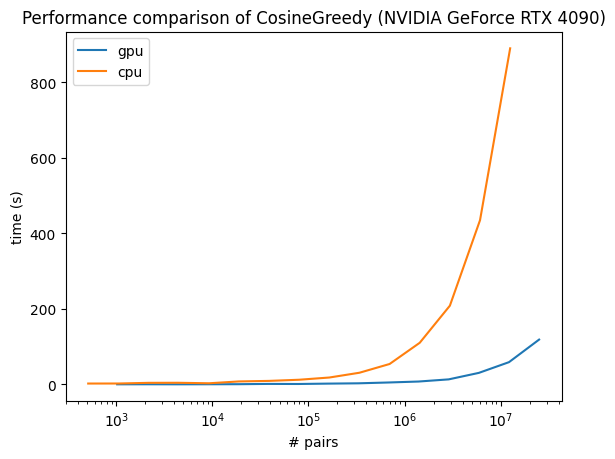

In [19]:

plt.semilogx(pairs_cu, times_cu, label='gpu')
plt.semilogx(pairs, times, label='cpu')
plt.title(f"Performance comparison of CosineGreedy ({torch.cuda.get_device_name()})")
plt.xlabel("# pairs")
plt.ylabel("time (s)")
plt.legend()
plt.show()